<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [65]:
!ls sarcasm/

test-balanced.csv
test-unbalanced.csv
train-balanced-sarcasm.csv


In [61]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import model_selection

In [4]:
train_df = pd.read_csv('sarcasm/train-balanced-sarcasm.csv')

In [5]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [7]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [8]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

In [9]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions

## 1. Exploratory analysis

In [13]:
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [16]:
cnt_srs = train_df['label'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Label Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="LabelCount")

## target distribution ##
labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Label distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

In [32]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(20.0,12.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout() 

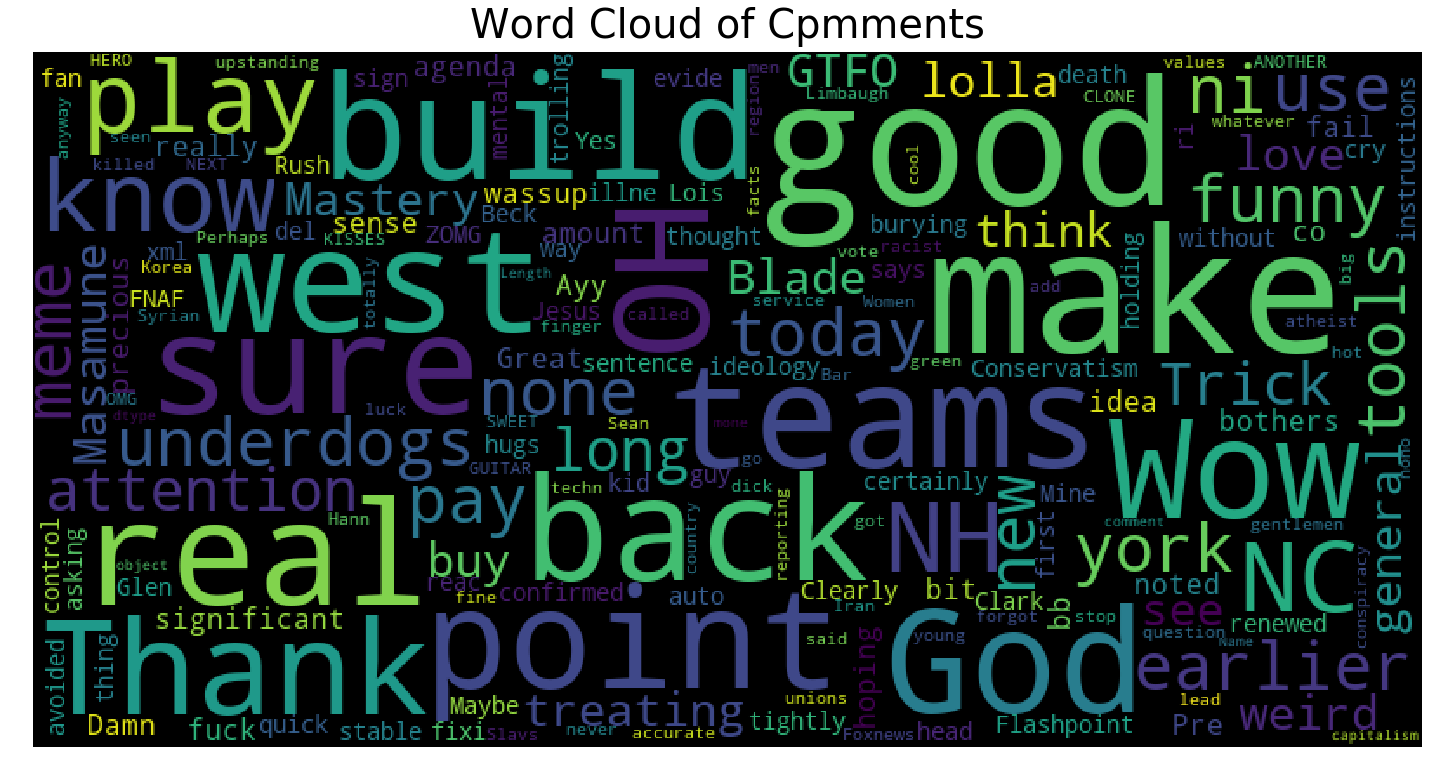

In [35]:
plot_wordcloud(train_df["comment"], title="Word Cloud of Cpmments")
plt.show()

In [38]:
from collections import defaultdict
train1_df = train_df[train_df["label"]==1]
train0_df = train_df[train_df["label"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace


freq_dict = defaultdict(int)
for sent in train0_df["comment"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')


freq_dict = defaultdict(int)
for sent in train1_df["comment"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of 0 label", 
                                          "Frequent words of 1 label"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

C:\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [39]:
freq_dict = defaultdict(int)
for sent in train0_df["comment"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["comment"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of 0 label", 
                                          "Frequent bigrams of 1 label"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

C:\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [40]:
freq_dict = defaultdict(int)
for sent in train0_df["comment"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["comment"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams of 0 label", 
                                          "Frequent trigrams of 1 label"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

C:\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [45]:
import string
## Number of words in the text ##
train_df["num_words"] = train_df["comment"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["comment"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["comment"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["comment"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['comment'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["comment"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["comment"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["comment"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



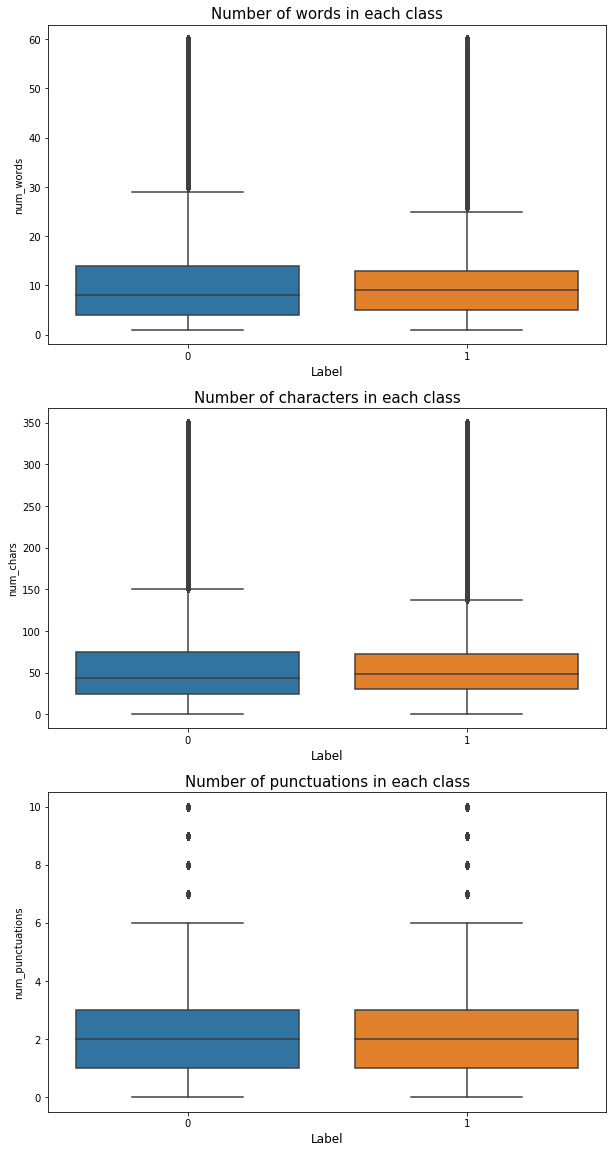

In [49]:
## Truncate some extreme values for better visuals ##
train_df['num_words'].loc[train_df['num_words']>60] = 60 #truncation for better visuals
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
train_df['num_chars'].loc[train_df['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='label', y='num_words', data=train_df, ax=axes[0])
axes[0].set_xlabel('Label', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='label', y='num_chars', data=train_df, ax=axes[1])
axes[1].set_xlabel('Label', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='label', y='num_punctuations', data=train_df, ax=axes[2])
axes[2].set_xlabel('Label', fontsize=12)
#plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

## 2. Building model

In [83]:
# Get the tfidf vectors 
#train_texts, valid_texts, y_train, y_valid
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
                           random_state=17, verbose=1)
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [84]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.9min finished


Wall time: 3min 39s


Pipeline(memory=None,
     steps=[('tf_idf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,... penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
          verbose=1, warm_start=False))])

In [85]:
%%time
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

Wall time: 11.3 s


In [86]:
accuracy_score(y_valid, valid_pred)

0.72051967992908417

In [87]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

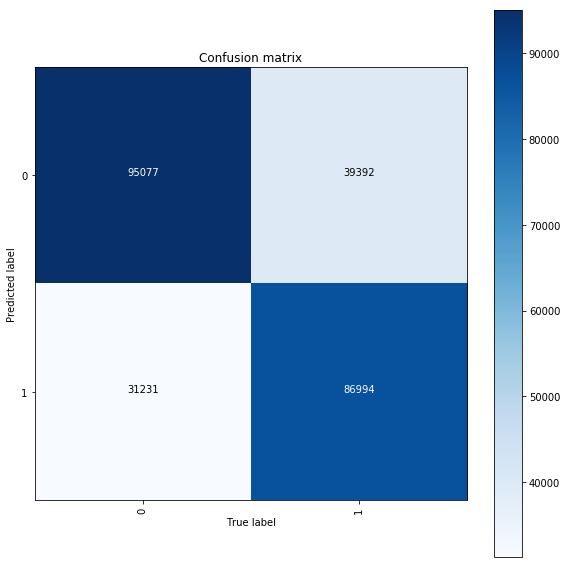

In [90]:
plot_confusion_matrix(y_valid, valid_pred, 
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))
plt.show()

In [91]:
import eli5
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

Weight?,Feature
+9.755,yes because
+8.224,clearly
+7.796,obviously
+7.456,yeah because
+7.229,totally
+6.114,because
+6.008,how dare
+5.963,right because
+5.650,but thought
+5.155,duh


## 3. Improving the model

In [92]:
subreddits = train_df['subreddit']
train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)

In [93]:
tf_idf_texts = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

In [94]:
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_valid_texts = tf_idf_texts.transform(valid_texts)

In [95]:
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)

In [96]:
from scipy.sparse import hstack
X_train = hstack([X_train_texts, X_train_subreddits])
X_valid = hstack([X_valid_texts, X_valid_subreddits])

In [97]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.3min finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
          verbose=1, warm_start=False)

In [98]:
valid_pred = logit.predict(X_valid)

In [99]:
accuracy_score(y_valid, valid_pred)

0.7237528394025976